In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [14]:
import time, io
from tqdm import tqdm
import tensorflow as tf
import sklearn
from PIL import Image
import numpy as np
import pickle
from cleverhans import utils_tf
from util import cvt2Image, sparse_tuple_from

In [15]:
from calamari_ocr.ocr.backends.tensorflow_backend.tensorflow_model import TensorflowModel
from calamari_ocr.ocr import Predictor
checkpoint = '/home/chenlu/calamari/models/antiqua_modern/4.ckpt.json'
predictor = Predictor(checkpoint=checkpoint, batch_size=1, processes=10)

Checkpoint version 1 is up-to-date.
charset: ['', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '}']
Using CUDNN LSTM backend on GPU
Successfully load the model's weights
INFO:tensorflow:Restoring parameters from /home/chenlu/calamari/models/antiqua_modern/4.ckpt


In [16]:
network = predictor.network
sess, graph = network.session, network.graph
codec = network.codec
charset = codec.charset
encode, decode = codec.encode, codec.decode
code2char, char2code = codec.code2char, codec.char2code

In [17]:
def invert(data): # 反色
    if data.max() < 1.5:
        return 1 - data
    else:
        return 255 - data

def transpose(data): # 旋转90度
    if len(data.shape) != 2:
        return np.swapaxes(data, 1, 2)
    else:
        return data.T

def cvt2raw(data):
    return transpose(invert(data))

def show(img):
    return cvt2Image(cvt2raw(img))

In [128]:
# build graph
with graph.as_default():
    # _ 是data_iterator如果是dataset input的话
    inputs, input_seq_len, targets, dropout_rate, _, _ = network.create_placeholders(
    )
    output_seq_len, time_major_logits, time_major_softmax, logits, softmax, decoded, sparse_decoded, scale_factor, log_prob = \
                        network.create_network(inputs, input_seq_len, dropout_rate, reuse_variables=tf.AUTO_REUSE)
    loss = tf.nn.ctc_loss(labels=targets,
                          inputs=time_major_logits,
                          sequence_length=output_seq_len,
                          time_major=True,
                          ctc_merge_repeated=True,
                          ignore_longer_outputs_than_inputs=True)
    loss = -tf.reduce_mean(loss, name='loss')
    grad, = tf.gradients(loss, inputs)

    # Normalize current gradient and add it to the accumulated gradient
    red_ind = list(range(1, len(grad.get_shape())))
    avoid_zero_div = tf.cast(1e-12, grad.dtype)
    divisor = tf.reduce_mean(tf.abs(grad), red_ind, keepdims=True)
    norm_grad = grad / tf.maximum(avoid_zero_div, divisor)

    m = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="momentum")
    acc_m = m + norm_grad
    
    # watermark mask
    mask = tf.placeholder(tf.float32,
                       shape=inputs.get_shape().as_list(),
                       name="mask")
    grad = tf.multiply(acc_m, mask, name="mask_op")
    # eps_iter = 0.01
    # ord=np.inf
    optimal_perturbation = tf.sign(grad)
    optimal_perturbation = tf.stop_gradient(optimal_perturbation)
    scaled_perturbation_inf = utils_tf.mul(0.01, optimal_perturbation)
    # ord=1
    abs_grad = tf.abs(grad)
    max_abs_grad = tf.reduce_max(abs_grad, axis=red_ind, keepdims=True)
    tied_for_max = tf.to_float(tf.equal(abs_grad, max_abs_grad))
    num_ties = tf.reduce_sum(tied_for_max, axis=red_ind, keepdims=True)
    optimal_perturbation = tf.sign(grad) * tied_for_max / num_ties
    scaled_perturbation_1 = utils_tf.mul(0.01, optimal_perturbation)
    # ord=2
    square = tf.maximum(
        1e-12, tf.reduce_sum(tf.square(grad), axis=red_ind, keepdims=True))
    optimal_perturbation = grad / tf.sqrt(square)
    scaled_perturbation_2 = utils_tf.mul(0.01, optimal_perturbation)

Using CUDNN LSTM backend on GPU


In [19]:
clip_min, clip_max = 0.0, 1.0
eps = 0.2
nb_iter = 1000
batch_size = 100
pert_type = '2'
eps_iter = 5.0
case = 'easy'
font_name = 'Arial' # 'Courier' 'Georgia' 'Helvetica' 'times' 'Arial'

img_data_path = '/home/chenlu/research/TextRecognitionDataGenerator/word_image_data'
with open(f'{img_data_path}/{font_name}-{case}.pkl', 'rb') as f:
    img_list, input_img, len_x, gt_txt, target_txt = pickle.load(f)
input_img = np.asarray(input_img)
nb_sample = 50
input_img, len_x, gt_txt, target_txt = input_img[:nb_sample], len_x[:nb_sample], gt_txt[:nb_sample], target_txt[:nb_sample]

title = f"{font_name}-{case}-l{pert_type}-eps{eps}-ieps{eps_iter}-iter{nb_iter}"
with open(f'attack_result/{title}.pkl', 'rb') as f:
    adv_img, record_adv_text, record_iter, (duration, total_iter) = pickle.load(f)
adv_img, record_adv_text, record_iter = adv_img[:nb_sample], record_adv_text[:nb_sample], record_iter[:nb_sample]

In [20]:
from skimage import morphology
import cv2
def find_wm_pos(adv_img, input_img, ret_frame_img=False):
    pert = np.abs(cvt2raw(adv_img) - cvt2raw(input_img))
    pert = (pert > 1 * 1e-2) * 255.0
    wm_pos_list = []
    frame_img_list = []
    for src in pert:
        kernel = np.ones((3, 3), np.uint8)  # 设置卷积核3*3
        dilate = cv2.dilate(src, kernel, iterations=2)  # 图像的膨胀
        erode = cv2.erode(dilate, kernel, iterations=2)  # 图像的腐蚀
        remove = morphology.remove_small_objects(erode.astype('bool'), min_size=0)
        contours, _ = cv2.findContours((remove * 255).astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        wm_pos, frame_img = [], []
        for cont in contours:
            left_point = cont.min(axis=1).min(axis=0)
            right_point = cont.max(axis=1).max(axis=0)
            wm_pos.append(np.hstack((left_point, right_point)))
            if ret_frame_img:
                img = cv2.rectangle(
                    (remove * 255).astype('uint8'), (left_point[0], left_point[1]),
                    (right_point[0], right_point[1]), (255, 255, 255), 2)
                frame_img.append(img)
        wm_pos_list.append(wm_pos)
        frame_img_list.append(frame_img)
    
    if ret_frame_img:
        return (wm_pos_list, frame_img_list)
    else:
        return wm_pos_list

In [22]:
pos, frames = find_wm_pos(adv_img, input_img, True)

In [23]:
# 按面积大小把pos从大到小排个序
new_pos = []
for _pos in pos:
    if len(_pos) > 1:
        new_pos.append(sorted(_pos, key=lambda x: (x[3]-x[1])*(x[2]-x[0]), reverse=True))
    else:
        new_pos.append(_pos)
pos = new_pos

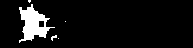

In [25]:
cvt2Image(frames[0][5])

In [26]:
from trdg.generators import GeneratorFromStrings

def gen_wm(RGB):
    generator = GeneratorFromStrings(
        strings=['eccv'],
        count=1,  # 五种字体
        fonts=['Impact.ttf'],  # default: []
        language='en',
        size=100,  # 32
        skewing_angle=10,
        random_skew=False,
        blur=0,
        random_blur=False,
        # gaussian noise (0), plain white (1), quasicrystal (2) or picture (3)
        background_type=1,
        distorsion_type=0,  # None(0), Sine wave(1),Cosine wave(2),Random(3)
        distorsion_orientation=0,
        is_handwritten=False,
        width=-1,
        alignment=1,
        text_color=RGB2Hex(RGB),
        orientation=0,
        space_width=1.0,
        character_spacing=0,
        margins=(0, 0, 0, 0),
        fit=True,
    )
    img_list = [img for img, _ in generator]
    return img_list[0]

In [27]:
# RGB格式颜色转换为16进制颜色格式
def RGB2Hex(RGB): # RGB is a 3-tuple
    color = '#'
    for num in RGB:
        color += str(hex(num))[-2:].replace('x', '0').upper()
    return color

In [159]:
# 得到水印 mask
grayscale = 0 # 灰度值在 76-226 之间有对应的彩色水印值
color = (grayscale, grayscale, grayscale)
wm_img = gen_wm(color)
wm_arr = np.array(wm_img.convert('L'))
kernel = np.ones((5, 5), np.uint8)
wm_arr = cv2.dilate(wm_arr, kernel, 2)
wm_arr = cv2.erode(wm_arr, kernel, 2)
bg_mask = ~(wm_arr != 255)

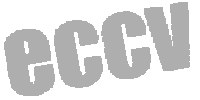

In [160]:
# 灰色水印
grayscale = 174 # 灰度值在 76-226 之间有对应的彩色水印值, 为了增加扰动后还在范围内，128-174
color = (grayscale, grayscale, grayscale)
wm_img = np.array(Image.new(mode="RGB", size=wm_img.size, color=color))
wm_img[bg_mask] = 255
wm_img = Image.fromarray(wm_img)
wm_img

In [10]:
large_l = []
green_val = np.array(list(range(256)))
for _gi in range(256):
    _r, _g, _b = 255, _gi, 0
    large_l.append(_r * 19595 + _g * 38470 + _b * 7471 + 0x8000)
normal_l = np.array(large_l, dtype='uint32') >> 16
l0_1 = normal_l / 255
range_min, range_max = l0_1.min(), l0_1.max()
gray_green_map = dict(list(zip(normal_l, green_val)))
gray_green_map_array = np.ones((255, ))
gray_green_map_array[:76] = gray_green_map[76]
gray_green_map_array[227:] = gray_green_map[226]
for gray, green in gray_green_map.items():
    gray_green_map_array[gray] = green

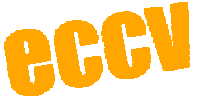

In [11]:
# 彩色水印
green_v = gray_green_map[grayscale]
color = (255, green_v, 0)
wm_img = np.array(Image.new(mode="RGB", size=wm_img.size, color=color))
wm_img[bg_mask] = 255
wm_img = Image.fromarray(wm_img)
wm_img

In [31]:
def get_text_mask(img: np.array):
    if img.max() <= 1:
        return img < 1 / 1.25
    else:
        return img < 255 / 1.25

In [173]:
# logits of input images.
logits0 = []
pred_img = input_img
batch_iter = len(input_img) // batch_size
batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
for batch_i in range(batch_iter):
    batch_img = pred_img[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_logits0 = sess.run(logits,
                             feed_dict={
                                 inputs: batch_img,
                                 input_seq_len: batch_len_x,
                                 dropout_rate: 0,
                             })
    logits0 += [l for l in batch_logits0]
logits0 = np.asarray(logits0)
lgt = np.roll(logits0, shift=1, axis=2)  # 可以与charset的index对应上了
labels = np.argmax(lgt, axis=-1)  # 概率最大的

In [ ]:
# logits of input images.
with graph.as_default():
    logits0 = sess.run(logits,
                        feed_dict={
                            inputs: input_img,
                            input_seq_len: len_x,
                            dropout_rate: 0,
                        })
lgt = np.roll(logits0, shift=1, axis=2)  # 可以与charset的index对应上了
labels = np.argmax(lgt, axis=-1)  # 概率最大的
# find the position of target character
pos_x_list = []
for idx in range(len(labels)):
    text_index = decode(labels[idx])
    j = 0
    for i, c in enumerate(text_index):
        if c != '' and ((not (i > 0 and text_index[i] == text_index[i - 1])) or
                        (i > 1 and text_index[i] == text_index[i - 2])):
            if gt_txt[idx][j] != target_txt[idx][j]:
                pos_x_list.append(int(i / len(text_index) * input_img.shape[1]))
            j += 1

In [161]:
wm0_img_list = []
wm_mask_list = []
text_mask_list = []
y_pos = -int(wm_img.size[0] * np.tan(10 * np.pi / 180))
for i in range(len(input_img)):
    text_img = show(input_img[i])
    text_mask = get_text_mask(np.array(text_img)) # 得到 text 的 mask(bool)
    rgb_img = Image.new(mode="RGB", size=text_img.size, color=(255, 255, 255))
    rgb_img.paste(wm_img, box=(pos_x_list[i] + 10, y_pos)) # 先贴 wm
#     rgb_img.paste(wm_img, box=(pos[i][0][0]+20, y_pos)) # 先贴 wm
    wm_mask = (np.array(rgb_img.convert('L')) != 255) # 得到 wm 的 mask(bool)
    rgb_img.paste(text_img, mask=cvt2Image(text_mask)) # 再贴 text
    
    wm0_img_list.append(rgb_img)
    wm_mask_list.append(transpose(wm_mask))
    text_mask_list.append(transpose(text_mask))
wm_mask = np.asarray(wm_mask_list)
text_mask = np.asarray(text_mask_list)

In [162]:
wm0_img = np.asarray([cvt2raw(np.array(img.convert('L'))) / 255 for img in wm0_img_list])

In [163]:
# 大数据集查看 batch predict
record_text = []
pred_img = wm0_img
batch_iter = len(input_img) // batch_size
batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
for batch_i in range(batch_iter):
    batch_img = pred_img[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_text = sess.run(decoded,
                              feed_dict={
                                  inputs: batch_img,
                                  input_seq_len: batch_len_x,
                                  dropout_rate: 0,
                              })
    batch_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_text)
    record_text += [''.join(decode(index)) for index in batch_index]
    
# # 小数据集查看
# with graph.as_default():
#     wm0_text = sess.run(decoded,
#                         feed_dict={
#                             inputs: wm0_img,
#                             input_seq_len: len_x,
#                             dropout_rate: 0,
#                         })
#     wm0_index = TensorflowModel._TensorflowModel__sparse_to_lists(wm0_text)
#     wm0_text = [''.join(decode(index)) for index in wm0_index]

cnt = 0
for pred_txt, raw_txt in zip(record_text, gt_txt):
    if pred_txt == raw_txt:
        cnt += 1
print(f"predict accuracy: {cnt / len(gt_txt)}")

predict accuracy: 0.93


In [164]:
target_index_list = [np.asarray([c for c in encode(t)]) for t in target_txt]
wm_img = wm0_img
nb_iter = 500
with graph.as_default():
    adv_img = wm_img.copy()
    m0 = np.zeros(input_img.shape)
    record_iter = np.zeros(input_img.shape[0])  # 0代表没成功
    start = time.time()
    for i in tqdm(range(nb_iter)):
        batch_iter = len(input_img) // batch_size
        batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
        for batch_i in range(batch_iter):
            batch_input_img = wm_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_m0 = m0[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_txt = target_txt[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_tmp_y = [np.asarray([c - 1 for c in encode(t)])for t in batch_target_txt]
            batch_y = sparse_tuple_from(batch_tmp_y)
            batch_mask = wm_mask[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_record_iter = record_iter[batch_size * batch_i:batch_size * (batch_i + 1)]
            
            scaled_perturbation = scaled_perturbation_2 if pert_type == '2' else scaled_perturbation_inf
            batch_pert = sess.run(scaled_perturbation,
                                  feed_dict={
                                      inputs: batch_adv_img,
                                      input_seq_len: batch_len_x,
                                      m: batch_m0,
                                      targets: batch_y,
                                      mask: batch_mask,
                                      dropout_rate: 0,
                                  })
            batch_pert[batch_record_iter != 0] = 0
            batch_adv_img = batch_adv_img + eps_iter * batch_pert
            batch_adv_img = batch_input_img + np.clip(batch_adv_img - batch_input_img, -eps, eps)
            batch_adv_img = np.clip(batch_adv_img, clip_min, clip_max)
            adv_img[batch_size * batch_i:batch_size * (batch_i + 1)] = batch_adv_img
        
        record_adv_text = []
        for batch_i in range(batch_iter):
            batch_adv_img = adv_img[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_target_index = target_index_list[batch_size * batch_i:batch_size * (batch_i + 1)]
            batch_adv_text = sess.run(decoded,
                                      feed_dict={
                                          inputs: batch_adv_img,
                                          input_seq_len: batch_len_x,
                                          dropout_rate: 0,
                                      })
            batch_adv_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_adv_text)
            record_adv_text += [''.join(decode(index)) for index in batch_adv_index]
            for j in (range(len(batch_target_index))):
                # attack img j successfully at iter i
                adv_index, target_index = batch_adv_index[j], batch_target_index[j]
                idx_j = batch_size * batch_i + j
                if np.sum(adv_index != target_index) == 0 and record_iter[idx_j] == 0:
                    record_iter[idx_j] = i
        if np.sum(record_iter == 0) == 0:  # all examples are successful
            print(i, 'break')
            break
    duration = time.time() - start
    print(f"Time cost {duration} s")

100%|██████████| 1000/1000 [01:34<00:00, 10.59it/s]

Time cost 94.44919872283936 s


In [171]:
cnt = 0
for pred_t, target_t in zip(record_adv_text, target_txt):
    if pred_t == target_t:
        cnt += 1
print(f"predict accuracy: {cnt / len(gt_txt)}")

predict accuracy: 0.4


stater stater


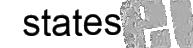

In [172]:
i = 6
print(target_txt[i], record_adv_text[i])
show(adv_img[i])

In [50]:
# 大数据集查看 batch predict
record_text = []
pred_img = adv_img
batch_iter = len(input_img) // batch_size
batch_iter = batch_iter if len(input_img) % batch_size == 0 else batch_iter + 1
for batch_i in range(batch_iter):
    batch_img = pred_img[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_len_x = len_x[batch_size * batch_i:batch_size * (batch_i + 1)]
    batch_text = sess.run(decoded,
                              feed_dict={
                                  inputs: batch_img,
                                  input_seq_len: batch_len_x,
                                  dropout_rate: 0,
                              })
    batch_index = TensorflowModel._TensorflowModel__sparse_to_lists(batch_text)
    record_text += [''.join(decode(index)) for index in batch_index]

In [53]:
cnt = 0
for pred_t, target_t in zip(record_text, target_txt):
    if pred_t == target_t:
        cnt += 1
cnt / len(gt_txt)

0.99

# gray to color

In [ ]:
# def cvt2rgb(gray_img: np.array, text_mask: np.array) -> np.array:
#     op_mask = (~(gray_img == 255)) & (~text_mask) # not_bg & not_text
#     rgb_img = np.array(Image.fromarray(gray_img).convert('RGB'))
#     rgb_img[op_mask, 0] = 255
#     rgb_img[op_mask, 1] = gray_green_map_array[gray_img[op_mask]]
#     rgb_img[op_mask, 2] = 0
#     return rgb_img
# # 老办法循环
# rgb_img_list = []
# for i in range(len(text_mask_list)):
#     gray_img = np.array(show(adv_img[i]).convert('L'))
#     rgb_img = cvt2rgb(gray_img, text_mask_list[i])
#     rgb_img_list.append(rgb_img)
# i = 40
# gray_img = np.array(show(adv_img[i]).convert('L'))
# rgb_img = cvt2rgb(gray_img, text_mask_list[i])
# Image.fromarray(rgb_img)

In [ ]:
def cvt2rgb(gray_img, text_mask):
    gray_img = invert(gray_img)
    op_mask = (~(gray_img == 1)) & (~text_mask) # not_bg & not_text
    rgb_img = np.ones(list(gray_img.shape)+[3])
    rgb_img[:, :, :, 0] = gray_img
    rgb_img[:, :, :, 1] = gray_img
    rgb_img[:, :, :, 2] = gray_img
    rgb_img[op_mask, 0] = 1
    rgb_img[op_mask, 1] = (gray_img[op_mask] - 0.299) / 0.587
    rgb_img[op_mask, 2] = 0
    return invert(rgb_img)

In [ ]:
rgb_img = cvt2rgb(adv_img, text_mask)

In [ ]:
def rgb(rgb_img):
    if rgb_img.max() < 1.5:
        return Image.fromarray((rgb_img * 255).astype('uint8'))
    else:
        return Image.fromarray((rgb_img).astype('uint8'))

/* ITU-R Recommendation 601-2 (assuming nonlinear RGB) */
#define L(rgb)\
    ((INT32) (rgb)[0]*299 + (INT32) (rgb)[1]*587 + (INT32) (rgb)[2]*114) / 1000
#define L24(rgb)\
    ((rgb)[0]*19595 + (rgb)[1]*38470 + (rgb)[2]*7471 + 0x8000) >> 16;